[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/06_the_haunted_dag_and_the_causal_terror.ipynb)

# Chapter 6 - The Haunted DAG and The Causal Terror

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install --upgrade -q daft
  !pip install -q causalgraphicalmodels
  !pip install -q watermark
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from statsmodels.regression import linear_model

# visualization 
import matplotlib.pyplot as plt

import daft
from causalgraphicalmodels import CausalGraphicalModel

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,statsmodels,daft,causalgraphicalmodels

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5
statsmodels           : 0.13.1
daft                  : 0.1.2
causalgraphicalmodels : 0.0.4



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

In [6]:
### Tensorflow MCMC sampling helpers


In [7]:
USE_XLA = False              #@param
NUMBER_OF_CHAINS  = 2        #@param 
NUMBER_OF_BURNIN  = 500      #@param
NUMBER_OF_SAMPLES = 500      #@param
NUMBER_OF_LEAPFROG_STEPS = 4 #@param

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(jdc, 
              observed_data, 
              params, 
              init_state=None, 
              bijectors=None, 
              step_size = 0.1,
              num_chains=NUMBER_OF_CHAINS,                  
              num_samples=NUMBER_OF_SAMPLES, 
              burnin=NUMBER_OF_BURNIN):
        
    if init_state is None:
        init_state = list(jdc.sample(num_chains)[:-1])

    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  

    results, sample_stats = run_hmc_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, 
                           sample_stats=sampler_stats)

    return posterior, az_trace

In [8]:
### DATASET URLS & Utils

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"
MILK_DATASET_PATH = f"{_BASE_URL}/milk.csv"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"

In [10]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns,dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields) 



**Berkson's paradox** - A *false* observation of a *negative* coorelation between 2 positive traits.

Members of a population which have some positive trait tend to lack a second even though -:

* The traits may be unrelated

* Or, they may be even positively related.

e.g Resturants at good location have bad food even though location & food have no correlation

**Berkon's paradox** is also called **selection-distortion effect**.

The gist of the idea here is that when a sample is selected on a combination of 2 (or more) variables, the relationship between those 2 variables is different after selection than it was before. 

Because of above, we should always be cautious of adding more predictor variables to our regression as it may introduce statistical selection with in the model. The phenomenon has a name and it is called **COLLIDER BIAS**.

There are actually 3 types of hazards when we add more predictor variables -

* Multicollinearity 
* Post treatment bias
* Collider bias

Collider - a beam in which two particles are made to collide (collision)



### Overthinking : Simulated Science Distorion





##### Code 6.1

A simulated example to demonstrate selection-distortion effect. It has been observed that newsworthiness and trustworthiness of papers accepted by journal are factors in getting the funding.

Below code shows how they correlated with each other.

In [11]:
# A simulated example to demonstrate selection-disortion 
#
# Here

_SEED = 1914

N = 200
p = 0.1  # proportion to select

# uncorrelated newsworthiness & trustworthiness
seed = tfp.util.SeedStream(_SEED, salt="")
nw = tfd.Normal(loc=0., scale=1.).sample(N, seed=seed()).numpy()
seed = tfp.util.SeedStream(_SEED, salt="")
tw = tfd.Normal(loc=0., scale=1.).sample(N, seed=seed()).numpy()

# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold

selected = np.where(s >= q, True, False)

np.corrcoef(tw[selected], nw[selected])[0, 1]

-0.828225254885134

This shows that nw (newsworthiness) & tw (trustworthiness) are **heavily negivately correlated**.

## 6.1 Multicollinearity

**Multicollinearity** happens when the predictor variables are stronly correlated.

When this happens the posterior distribution will seem to suggest that none of the variables is reliably associated with the outcome. 

Model will still infer correct results but it would be difficult to understand it.

### 6.1.1 Multicollinear legs

Here we create an artifical dataset about height & its relation to the length of the legs as predictor variables.

The two legs are more or less of same length so they are correlated with each other. Including both of the legs as the predictors result in multicollinearity

##### Code 6.2



In [12]:
_SEED = 909

N = 100

def generate_height_leg_data():
    seed = tfp.util.SeedStream(_SEED, salt="leg_exp")
    height = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed()).numpy()
    leg_prop = tfd.Uniform(low=0.4, high=0.5).sample(N, seed=seed()).numpy()

    # left & right leg as proportion + error
    leg_left = leg_prop * height + tfd.Normal(loc=0, scale=0.02).sample(N, seed=seed()).numpy()

    leg_right = leg_prop * height + tfd.Normal(loc=0, scale=0.02).sample(N, seed=seed()).numpy()

    # build a dataframe using above
    d = pd.DataFrame({
        "height" : height,
        "leg_left" : leg_left,
        "leg_right" : leg_right
    })

    return d

d = generate_height_leg_data()

d.describe()

,height,leg_left,leg_right
count,100.000000,100.000000,100.000000
mean,10.244188,4.586804,4.589090
std,1.971723,0.856999,0.857432
min,6.569585,2.711091,2.734310
25%,8.705090,3.959075,3.970327
50%,10.478082,4.628943,4.644671
75%,11.372977,5.143220,5.147640
max,15.219750,7.189007,7.178730


##### Code 6.3 

Very vague and bad priors are used in the model here so that we can be sure that priors are not responsible for what we are about to observe

In [13]:
tdf = df_to_tensors('SimulatedHeight', d, ['leg_left', 'leg_right', 'height'])

def model_6_1(leg_left_data, leg_right_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=10., scale=100., name="alpha"), sample_shape=1))
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=2., scale=10., name="betaL"), sample_shape=1))
      betaR = yield Root(tfd.Sample(tfd.Normal(loc=2., scale=10., name="betaR"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))

      mu = tf.squeeze(
          alpha[...,tf.newaxis] + \
          betaL[...,tf.newaxis] * leg_left_data + \
          betaR[...,tf.newaxis] * leg_right_data
      )
        
      scale = sigma[...,tf.newaxis]
        
      height = yield tfd.Independent(
                      tfd.Normal(loc=mu, scale=scale, name="height"), 
                      reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_1 = model_6_1(tdf.leg_left, tdf.leg_right)

In [14]:
NUM_CHAINS_FOR_6_1 = 2

# Note - 
# I got somewhat ok looking results with this init values
init_state = [
    tf.ones([NUM_CHAINS_FOR_6_1]),
    tf.ones([NUM_CHAINS_FOR_6_1]),
    tf.ones([NUM_CHAINS_FOR_6_1]),
    tf.ones([NUM_CHAINS_FOR_6_1])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_data = (tdf.height, )

posterior_6_1, trace_6_1 = sample_posterior(
                                jdc_6_1, 
                                observed_data=observed_data, 
                                num_chains=NUM_CHAINS_FOR_6_1,
                                init_state = init_state,
                                bijectors = bijectors,
                                num_samples=4000,
                                burnin=500,
                                params=['alpha', 'betaL', 'betaR', 'sigma'])

az.summary(trace_6_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.257,0.326,-0.259,0.783,0.048,0.034,47.0,118.0,1.06
betaL,0.900,0.882,-0.399,2.226,0.541,0.435,3.0,15.0,1.82
betaR,1.277,0.876,-0.017,2.564,0.544,0.438,3.0,18.0,1.85
sigma,0.662,0.047,0.586,0.733,0.001,0.001,1239.0,1910.0,1.00


Notice betaL and betaR values. How can they be so different ? Afterall we know that the legs are more or less of same lenght so their effects should be both equal. This is confusing indeed !

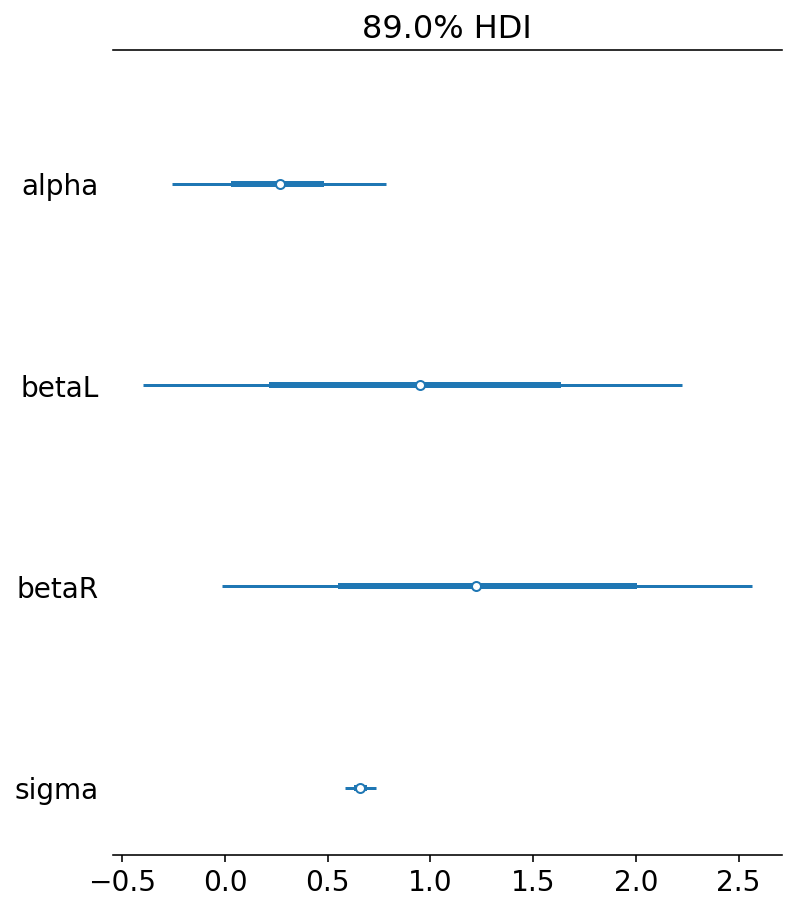

In [15]:
az.plot_forest(trace_6_1, hdi_prob=0.89, combined=True);

##### Code 6.5 

Looking at the bivariate posterior distribution for betaR & betaL.

Since both variables contain identical information, the posterior is a narrow ridge of negatively correlated values.

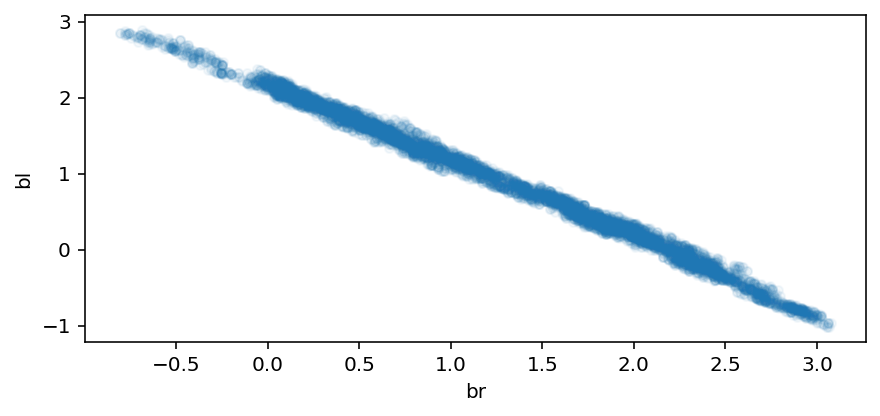

In [16]:
fig, ax = plt.subplots(1, 1, figsize=[7, 3])

plt.scatter(posterior_6_1['betaR'], posterior_6_1['betaL'], alpha=0.05, s=20)
ax.set_xlabel("br")
ax.set_ylabel("bl");

##### Code 6.6 

Below plot shows that the posterior distribution of sum of the two parameters is centered on the proper association of either leg with height

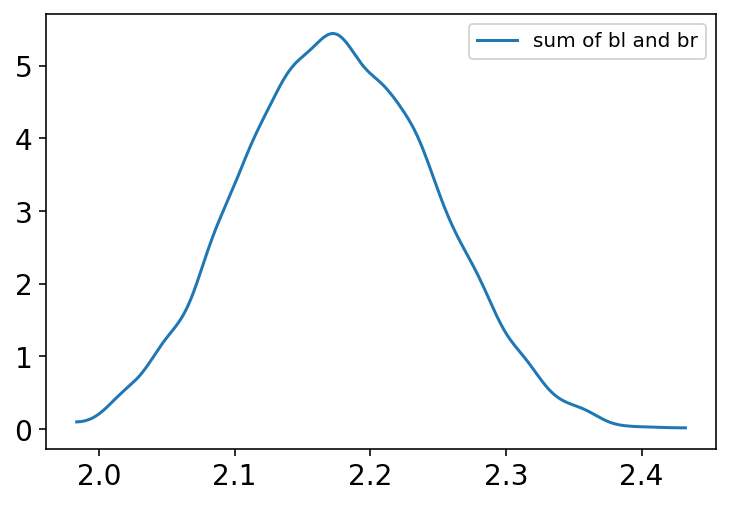

In [17]:
sum_blbr = posterior_6_1["betaL"] + posterior_6_1["betaR"]
az.plot_kde(sum_blbr.numpy(), label="sum of bl and br");

##### Code 6.7

We will now do the regression using only one leg and the posterior mean will be approximately the same.

Building the model using only left leg.

In [18]:
def model_6_2(leg_left_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=10., scale=100., name="alpha"), sample_shape=1))
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=2., scale=10., name="betaL"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))

      mu = tf.squeeze(
          alpha[...,tf.newaxis] + \
          betaL[...,tf.newaxis] * leg_left_data
      )
        
      scale = sigma[...,tf.newaxis]
        
      height = yield tfd.Independent(
                      tfd.Normal(loc=mu, scale=scale, name="height"), 
                      reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_2 = model_6_2(tdf.leg_left)

In [19]:
NUM_CHAINS_FOR_6_2 = 2

# Note - 
# I got somewhat ok looking results with this init values
init_state = [
    tf.ones([NUM_CHAINS_FOR_6_2]),
    tf.ones([NUM_CHAINS_FOR_6_2]),
    tf.ones([NUM_CHAINS_FOR_6_1])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_data = (tdf.height, )

posterior_6_2, trace_6_2 = sample_posterior(
                                jdc_6_2, 
                                observed_data=observed_data, 
                                num_chains=NUM_CHAINS_FOR_6_2,
                                init_state = init_state,
                                bijectors = bijectors,
                                num_samples=4000,
                                burnin=500,
                                params=['alpha', 'betaL','sigma'])

az.summary(trace_6_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.904,0.426,0.234,1.524,0.246,0.194,3.0,11.0,1.65
betaL,2.451,0.675,1.957,3.752,0.259,0.192,12.0,17.0,1.69
sigma,2.731,3.438,0.545,9.151,1.586,1.199,3.0,26.0,1.68


The value of `betaL` is now identical to `sum of betaL & betaL` (see the chart from Code 6.6) from previous models

### 6.1.2 Multicollinear milk

In real datasets, it may be difficult to identify the highly correlated predictors. This has the consequence of coming to a conclusion that none of the predictor is significant.

Here the primate milk dataset is used as another example for multicollinearity challenge.

##### Code 6.8

Loading the dataset and creating new standardized (centered) columns

In [20]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")

d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["F"] = d["perc.fat"].pipe(lambda x: (x - x.mean()) / x.std())
d["L"] = d["perc.lactose"].pipe(lambda x: (x - x.mean()) / x.std())

In [21]:
tdf = df_to_tensors("Milk", d, ['K', 'F', 'L'])

##### Code 6.9

We are building 2 models here.

* KCal regressed on perc.fat
* KCal regressed on perc.lactose

In [22]:
# KCal is regressed on perc.fat



def model_6_3(per_fat):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaF = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaF"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))    

      mu =  alpha[...,tf.newaxis] + betaF[...,tf.newaxis] * tf.transpose(per_fat[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_3 = model_6_3(tdf.F)

In [23]:
NUM_CHAINS_FOR_6_3 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_3]),
    tf.zeros([NUM_CHAINS_FOR_6_3]),
    tf.ones([NUM_CHAINS_FOR_6_3]),    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
    tfb.Exp()
]

posterior_6_3, trace_6_3 = sample_posterior(
                            jdc_6_3, 
                            observed_data=(tdf.K,),
                            init_state = init_state,
                            bijectors = bijectors,
                            params=['alpha', 'betaF', 'sigma'])

In [24]:
# KCal is regressed on perc.lactose

def model_6_4(per_lac):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaL"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha[...,tf.newaxis] + betaL[...,tf.newaxis] * tf.transpose(per_lac[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_4 = model_6_4(tdf.L)

In [25]:
NUM_CHAINS_FOR_6_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_4]),
    tf.zeros([NUM_CHAINS_FOR_6_4]),
    tf.ones([NUM_CHAINS_FOR_6_4]),    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
    tfb.Exp()
]

posterior_6_4, trace_6_4 = sample_posterior(
                                jdc_6_4, 
                                observed_data=(tdf.K,),
                                init_state = init_state,
                                bijectors = bijectors,
                                params=['alpha', 'betaL', 'sigma'])

In [26]:
az.summary(trace_6_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.005,0.082,-0.110,0.144,0.007,0.005,131.0,130.0,1.01
betaF,0.853,0.093,0.676,0.985,0.010,0.007,92.0,197.0,1.03
sigma,0.488,0.075,0.369,0.586,0.004,0.003,467.0,70.0,1.01


In [27]:
az.summary(trace_6_4, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.067,-0.109,0.100,0.007,0.005,94.0,147.0,1.01
betaL,-0.904,0.076,-1.021,-0.789,0.006,0.004,169.0,322.0,1.00
sigma,0.411,0.062,0.321,0.505,0.002,0.002,747.0,259.0,1.01


Posterior for betaF & betaL are mirror images of each other.

This seems to imply that both predictors have strong association with the outcome. Notice the `sd` of both the predictors; they are quite low.

In next section we will see what happens when we combine both of them in the regression model

##### Code 6.10

We build a model where we include both of the predictors (per_fat & per_lac)

In [28]:
def model_6_5(per_fat, per_lac):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaF = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaF"), sample_shape=1))      
      betaL = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaL"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha[...,tf.newaxis] + \
                    betaF[...,tf.newaxis] * tf.transpose(per_fat[...,tf.newaxis]) + \
                    betaL[...,tf.newaxis] * tf.transpose(per_lac[...,tf.newaxis])
    
      scale = sigma[..., tf.newaxis]  
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_5 = model_6_5(tdf.F, tdf.L)

In [29]:
NUM_CHAINS_FOR_6_5 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_5]),
    tf.zeros([NUM_CHAINS_FOR_6_5]),
    tf.zeros([NUM_CHAINS_FOR_6_5]),
    tf.ones([NUM_CHAINS_FOR_6_5])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

posterior_6_5, trace_6_5 = sample_posterior(
                    jdc_6_5, 
                    observed_data=(tdf.K,), 
                    num_chains=NUM_CHAINS_FOR_6_5,
                    init_state=init_state,
                    bijectors=bijectors,
                    params=['alpha', 'betaF', 'betaL', 'sigma'])

az.summary(trace_6_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.005,0.071,-0.123,0.102,0.004,0.003,373.0,602.0,1.00
betaF,0.271,0.195,-0.029,0.595,0.012,0.008,281.0,306.0,1.01
betaL,-0.641,0.194,-1.014,-0.386,0.012,0.008,270.0,316.0,1.01
sigma,0.415,0.060,0.329,0.506,0.003,0.002,566.0,248.0,1.01


Notice how the standard deviations of the posterior for betaF & betaL has jumped up significantly.

per_fat & per_lac both contain much of the same information and can be substitued for each other. Therefore, the model has not choice but to describe a long ridge of combination of betaF & betaL that are equally plaussible.

##### Code 6.11

We plot again like in the legs example to visualize the relationship

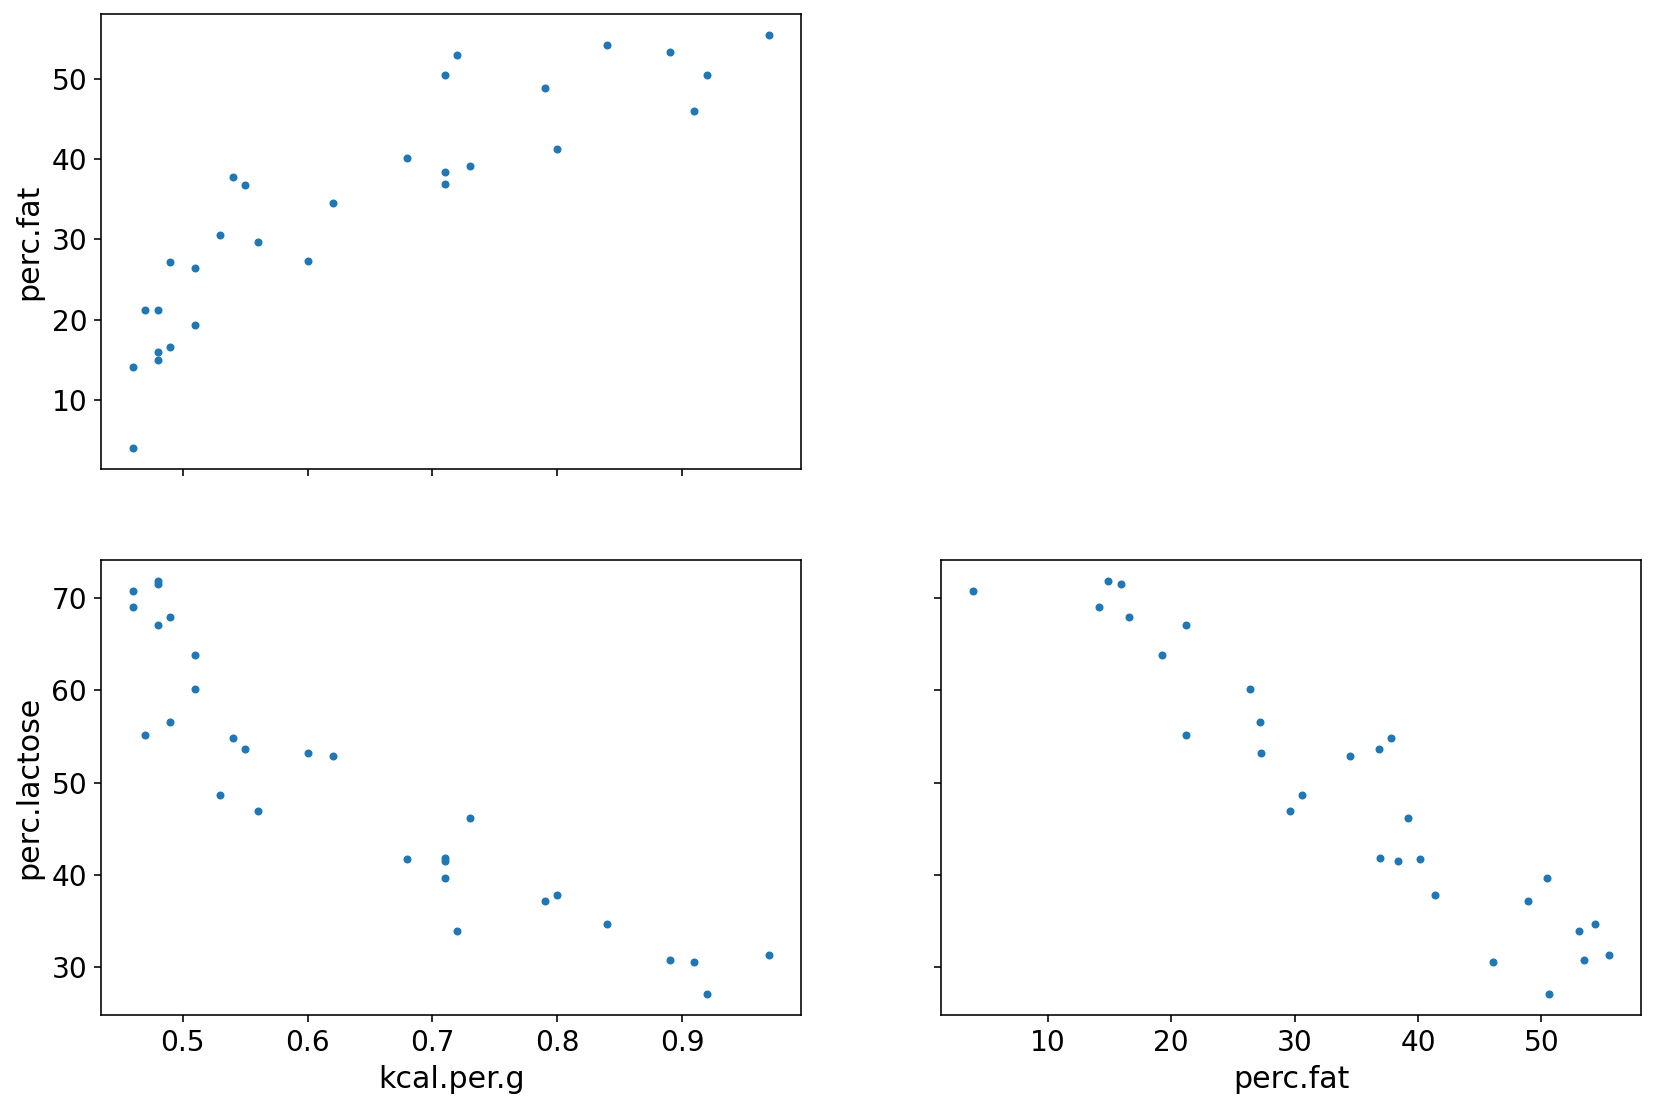

In [30]:
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"));

* perc.fat is positively related to outcome

* perc.lac is negatively related to outcome

* perc.fat & perc.lac are negatively coorelated to each other

Either of them helps in predicting KCal but neither helps much once we already know the other.

### Overthinking : Simulating collinearity

Simulating collinearity using Milk dataset

##### Code 6.12



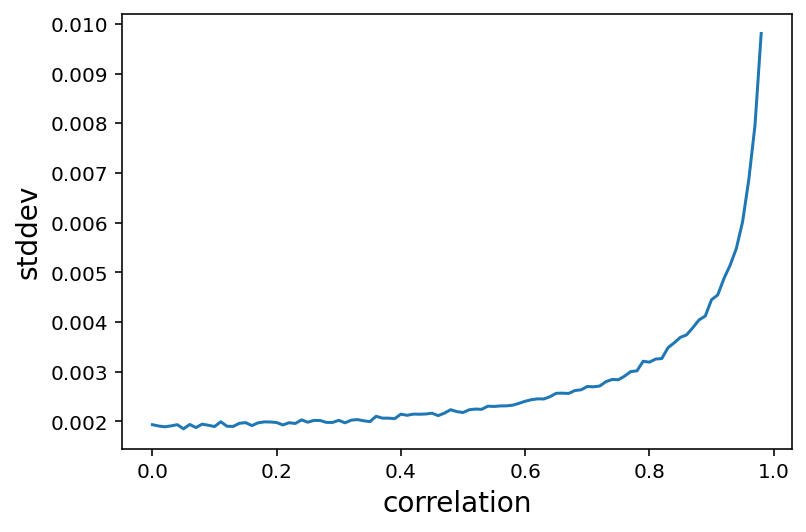

In [31]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")

def simcoll(r = 0.9):
    
    mean = r * d["perc.fat"].values
    sd = np.sqrt((1 - r ** 2) * np.var(d["perc.fat"].values))
    
    x = tfd.Normal(loc=mean, scale=sd).sample()
    
    X = np.column_stack((d['perc.fat'], x))
    m = linear_model.OLS(d['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

## 6.2 Post-treatment bias

**Omitted Variable bias** - Problems that arise because of **not** including predictior variables

**Post-treatment bias** - Problems that arise becuase of including **improper** predictor variables

##### Code 6.13

Simulate data to see what goes wrong when we include a **post-treatment** variable

In [32]:
_SEED = 71

# Note - even after providing SeedStream and generated seeds
# it still does not respect it
def simulate():
    seed = tfp.util.SeedStream(_SEED, salt="sim_heights")

    # number of plants
    N = 100

    # simulate initial heights
    h0 = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed())

    # assign treatments and simulate fungus and growth
    treatment = tf.repeat([0., 1.], repeats=N // 2)
    
    fungus = tfd.Binomial(total_count=1., probs=(0.5 - treatment * 0.4)).sample(seed=seed())
    
    h1 = h0 + tfd.Normal(loc=5. - 3. * fungus, scale=1.).sample(seed=seed())

    # compose a clean data frame
    d = {"h0":h0, "h1":h1, "treatment":treatment, "fungus":fungus}
    
    return d
    
d_dict = simulate()

az.summary(d_dict, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,9.894,2.143,6.421,12.93
h1,13.609,2.696,8.782,17.34
treatment,0.500,0.503,0.000,1.00
fungus,0.350,0.479,0.000,1.00


In [33]:
d = pd.DataFrame.from_dict(d_dict)

In [34]:
tdf = df_to_tensors('SimulatedTreatment', d, ['h0', 'h1', 'treatment', 'fungus'])

### 6.2.1 A prior is born

We will use a prior (see Code 6.14) that expects anything from 40% shrinkage up to 50% growth

##### Code 6.14

In [35]:
sim_p = tfd.LogNormal(loc=0., scale=0.25).sample((int(1e4),))
az.summary({"sim_p" : sim_p}, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
sim_p,1.028,0.257,0.614,1.403


##### Code 6.15

In this model only height (h0) as the predictor is included

In [36]:
def model_6_6(h0):
    def _generator():
      p = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.25, name="p"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = tf.squeeze(h0[tf.newaxis,...] * p[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_6 = model_6_6(tdf.h0)

In [37]:
NUM_CHAINS_FOR_6_6 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_6]),
    tf.ones([NUM_CHAINS_FOR_6_6])    
]

bijectors = [
    tfb.Exp(),
    tfb.Exp()
]

posterior_6_6, trace_6_6 = sample_posterior(
                    jdc_6_6, 
                    observed_data=(tdf.h1,), 
                    num_chains=NUM_CHAINS_FOR_6_6,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['p', 'sigma'])

az.summary(trace_6_6, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.357,0.019,1.327,1.387,0.000,0.000,1515.0,1562.0,1.0
sigma,1.903,0.137,1.681,2.117,0.004,0.003,1321.0,1623.0,1.0


The result shows that with height as the only predictor variable in the model there is about 40% growth on average.

##### Code 6.16

In this model we include treatment & fungus variables as well

In [38]:
def model_6_7(h0, treatment, fungus):
    def _generator():
      a = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.2, name="a"), sample_shape=1))      
      bt = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bt"), sample_shape=1))    
      bf = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bf"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      p = a[...,tf.newaxis] + bt[...,tf.newaxis] * treatment + bf[...,tf.newaxis] * fungus
        
      mu = h0 * p
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_7 = model_6_7(tdf.h0, tdf.treatment, tdf.fungus)

In [39]:
NUM_CHAINS_FOR_6_7 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_7]),
    tf.zeros([NUM_CHAINS_FOR_6_7]),
    tf.zeros([NUM_CHAINS_FOR_6_7]),
    tf.ones([NUM_CHAINS_FOR_6_7])    
]

bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

posterior_6_7, trace_6_7 = sample_posterior(
                    jdc_6_7, 
                    observed_data=(tdf.h1,), 
                    num_chains=NUM_CHAINS_FOR_6_7,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bt', 'bf', 'sigma'])

az.summary(trace_6_7, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.454,0.029,1.416,1.508,0.001,0.001,1076.0,1183.0,1.0
bt,-0.011,0.034,-0.066,0.040,0.001,0.001,1163.0,1033.0,1.0
bf,-0.275,0.034,-0.327,-0.218,0.001,0.001,1309.0,1630.0,1.0
sigma,1.385,0.097,1.233,1.537,0.005,0.003,430.0,809.0,1.0


Note that `a` is same as `p` in the previous model i.e. about 40% growth on average

Marginal posterior for `bt` (effect of treatment) is about 0 with a tight interval. This implies treatment is not associated with the growth.

Fungus (`bf`) seems to actually hurt the growth. 

Clearly this does not makes us happy because we know that the treatment does matter. Next section tries to find the answers.

### 6.2.2 Blocked by consequence

Fungus is a consequence of treatment i.e. fungus is a **post-treatment** variable.

When we include Fungus variable, the model tries to find whether a plat developed fungus or not. However, what we really want to understand is the impact of treatment on growth. 

This can be done by omitting the post-treatment variable *fungus*

##### Code 6.17

In this model, fungus predictor is not included

In [40]:
def model_6_8(h0, treatment):
    def _generator():
      a = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.2, name="a"), sample_shape=1))      
      bt = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bt"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      p = a[...,tf.newaxis] + bt[...,tf.newaxis] * treatment 
        
      mu = h0 * p
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_8 = model_6_8(tdf.h0, tdf.treatment)

In [41]:
NUM_CHAINS_FOR_6_8 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_8]),
    tf.zeros([NUM_CHAINS_FOR_6_8]),
    tf.ones([NUM_CHAINS_FOR_6_8])    
]

bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Exp()
]

posterior_6_8, trace_6_8 = sample_posterior(
                    jdc_6_8, 
                    observed_data=(tdf.h1,), 
                    num_chains=NUM_CHAINS_FOR_6_8,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bt', 'sigma'])

az.summary(trace_6_8, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.288,0.025,1.251,1.330,0.001,0.000,2037.0,1479.0,1.0
bt,0.133,0.035,0.075,0.186,0.001,0.000,3748.0,1747.0,1.0
sigma,1.789,0.126,1.599,1.994,0.004,0.003,928.0,1665.0,1.0


We can now see that `bt` (effect of treatment) has a positive impact on the model.

### 6.2.3 Fungus and d-separation

Above we built models by including and excluding various potential predictors. However, it helps to represent these relations graphically with the help of DAG.

##### Code 6.18

Here we are using `causalgraphicalmodel` package

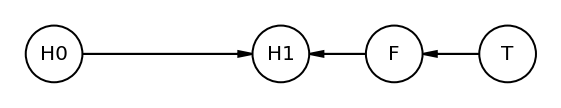

In [42]:
plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"],
    edges=[("H0", "H1"),
           ("F", "H1"),
           ("T", "F")])
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

The graph clearly shows how treatment's (T) impact on height (H1) is **blocked** by fungus (F)

Another way to say above is - If we condition on F it induces **D-SEPARATION**. The "d" stands for *directional*

H1 is conditionally independent of T if we include F (the blocker)


##### Code 6.19

In [43]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('T', 'H1', {'F'})
('T', 'H0', set())
('F', 'H0', set())


Here is how we want to read the above result -

* H0 is conditionally independent on T  (note the empty set). In other words, original height H0 should not be associated with T

* H0 is conditionally independent on F  (note the empty set). In other words, original height H0 should not be associated with F

* H1 is conditionally independent on T if we include F

##### Code 6.20

A synthetic data generation to modifiy the plant growth simulation so that fungus has no influence on growth, but moisture M influences both H1 and F

In [44]:
_SEED = 71

# Note - even after providing SeedStream and generated seeds
# it still does not respect it
def simulate():
    seed = tfp.util.SeedStream(_SEED, salt="sim_heights")

    # number of plants
    N = 1000

    # simulate initial heights
    h0 = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed())

    # assign treatments and simulate fungus and growth
    treatment = tf.repeat([0., 1.], repeats=N // 2)
    
    M = tf.cast(tfd.Bernoulli(probs=0.5).sample(N, seed=seed()), dtype=tf.float32)
    
    fungus = tfd.Binomial(total_count=1., probs=(0.5 - treatment * 0.4 + M * 0.4)).sample(seed=seed())
    
    h1 = h0 + tfd.Normal(loc=5. + 3. * M, scale=1.).sample(seed=seed())

    # compose a clean data frame
    d = {"h0":h0, "h1":h1, "treatment":treatment, "fungus":fungus}
    
    return d
    
d = simulate()

az.summary(d, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,9.994,2.06,6.494,12.935
h1,16.544,2.80,12.268,20.809
treatment,0.500,0.50,0.000,1.000
fungus,0.491,0.50,0.000,1.000


## 6.3 Collider bias

### 6.3.1 Collider of false sorrow


Question we consider in this section is how aging influences happiness ?

We also know that happiness (H) & age (A) both cause marriage (M). This makes marriage (M) a **collider**

H ----> M <----- A


##### Code 6.21

Simulating (synthetic data generation) happiness and its relationship with age & marriage

* Each year, 20 people are born with uniformly distributed happiness values
* Each year, each person ages one year. Happiness does not change.
* At age 18, individuals can be married. The odds of marriage each year are proportional to an individual's happiness
* Once married, an individual remains married
* After age 65, individuals leave the sample. (They move to Spain)

In [45]:
# Port of R code from here https://github.com/rmcelreath/rethinking/blob/master/R/sim_happiness.R
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = np.repeat(np.arange(1, N_years + 1), N_births)
    # sim happiness trait - never changes
    H = np.repeat(np.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = np.zeros(N_years * N_births, dtype=np.uint8)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = tfd.Bernoulli(logits=(H - 4.)).sample(seed=seed + i).numpy()
        return np.where((A >= i) & (M == 0.), married, M)

    def fori_loop(lower, upper, body_fun, init_val):
        val = init_val
        for i in range(lower, upper):
            val = body_fun(i, val)
        return val
    
    M = fori_loop(aom, max_age+1, update_M, M)    

    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d

d = sim_happiness(seed=1977, N_years=1000)

In [46]:
d.describe()

,age,married,happiness
count,1300.000000,1300.000000,1.300000e+03
mean,33.000000,0.292308,-8.335213e-17
std,18.768883,0.454998,1.214421e+00
min,1.000000,0.000000,-2.000000e+00
25%,17.000000,0.000000,-1.000000e+00
50%,33.000000,0.000000,-1.110223e-16
75%,49.000000,1.000000,1.000000e+00
max,65.000000,1.000000,2.000000e+00


##### Code 6.22

Rescaling age so that the range from 18 to 65 is one unit

We are adding a new column called "A" that ranges from 0 to 1 where 0 is age 18 and 1 is age 65

Happiness is on an arbitary scale from -2 to +2 

In [47]:
d2 = d[d.age > 17].copy()  # only adults
d2["A"] = (d2.age - 18) / (65 - 18)

##### Code 6.23

Here we are doing multiple regression. The linear model is 

$\mu_i$ = $\alpha_{MID[i]}$ + $\beta_A$ * $A_i$

In [48]:
d2["mid"] = d2.married

tdf = df_to_tensors('SimulatedHappiness', d2, {
    'mid' : tf.int32,
    'A'   : tf.float32,
    'happiness' : tf.float32
})

def model_6_9(mid, A):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=2))      
      bA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=2., name="bA"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = tf.squeeze(tf.gather(a, mid, axis=-1)) + bA[...,tf.newaxis] * A        
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_9 = model_6_9(mid=tdf.mid, A=tdf.A)

In [49]:
NUM_CHAINS_FOR_6_9 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_9, 2]),
    tf.zeros([NUM_CHAINS_FOR_6_9]),
    tf.ones([NUM_CHAINS_FOR_6_9])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tdf.happiness,)

posterior_6_9, trace_6_9 = sample_posterior(
                    jdc_6_9, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_9,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bA', 'sigma'])

az.summary(trace_6_9, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.186,0.063,-0.287,-0.089,0.002,0.001,1057.0,1553.0,1.0
a[1],1.341,0.088,1.209,1.483,0.003,0.002,928.0,1255.0,1.0
bA,-0.837,0.112,-1.008,-0.648,0.004,0.003,792.0,1200.0,1.0
sigma,0.989,0.022,0.956,1.025,0.001,0.000,1540.0,2012.0,1.0


The model here is quite sure that age is negatively associated with happiness.

##### Code 6.24

What would happen if omit the marriage status ?

Note - $a$ is not any more a vector; just a plain intercept

In [50]:
def model_6_10(A):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=1))      
      bA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=2., name="bA"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = a[...,tf.newaxis] + bA[...,tf.newaxis] * A        
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_10 = model_6_10(A=tdf.A)

In [51]:
NUM_CHAINS_FOR_6_10 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_10]),
    tf.zeros([NUM_CHAINS_FOR_6_10]),
    tf.ones([NUM_CHAINS_FOR_6_10])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tdf.happiness,)

posterior_6_10, trace_6_10 = sample_posterior(
                    jdc_6_10, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_10,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bA', 'sigma'])

az.summary(trace_6_10, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.078,-0.133,0.115,0.003,0.002,825.0,1563.0,1.0
bA,0.002,0.134,-0.192,0.231,0.005,0.004,704.0,1357.0,1.0
sigma,1.218,0.028,1.173,1.262,0.001,0.001,702.0,1048.0,1.0


The value is $a$ is close to zero. This implies that the model finds no association between age and happiness.

The pattern above is exactly what we should expect when condition on a **collider**. Here the **collider** is marriage status. It is a common consequence of age and happiness and therefore if we condition on it we are bound to induce a spurious association between the two causes

### 6.3.2 The hanted DAG

Collider may not be easily avoidable because they may be unmesasured causes. "Unmeasured" => Our DAG is haunted 


##### Code 6.25

Here we will simulate another dataset using which we will try to infer the direct influene of both parents (P) and grandparents (G) on the educational achievement of childern (C)

It should be obvious that G -> P, P->C and G->C 

In [52]:
N = 200  # number of grandparent-parent-child triads
b_GP = 1.  # direct effect of G on P
b_GC = 0.  # direct effect of G on C
b_PC = 1.  # direct effect of P on C
b_U = 2.  # direct effect of U on P and C

##### Code 6.26

Here is our "functional" (relationship) modeling

* P is some function of G & U
* C is some function of G, P & U
* G & U are not functions of any other known variables

In [53]:
def grand_parent_sim():
    seed = tfp.util.SeedStream(1, salt="sim_grand_parent")
    U = 2 * tfd.Bernoulli(probs=0.5).sample(seed=seed(), sample_shape=N) - 1
    G = tfd.Normal(loc=0.,scale=1.).sample(seed=seed(), sample_shape=N)    
    temp = b_GP * G + b_U * tf.cast(U, dtype=tf.float32)    
    P = tfd.Normal(loc=temp,scale=1.).sample(seed=seed())    
    temp2 = b_PC * P + b_GC * G + b_U * tf.cast(U, dtype=tf.float32)  
    C = tfd.Normal(loc=temp2,scale=1.).sample(seed=seed())

    d = pd.DataFrame({"C": C.numpy(), "P": P.numpy(), "G": G.numpy(), "U": U.numpy()})
    
    return d

d = grand_parent_sim()

d

,C,P,G,U
0,3.512862,1.650976,-1.042326,1
1,-4.590997,-1.555232,0.232263,-1
2,4.886199,3.082321,1.986989,1
3,1.636396,1.243976,-1.034003,1
4,-8.797684,-5.349887,-3.269576,-1
...,...,...,...,...
195,3.745021,0.391891,0.254253,1
196,-4.513893,-2.212740,-1.100699,-1
197,-3.206512,-0.455612,0.602985,-1
198,1.082468,-0.115803,0.106212,1


In [54]:
tdf = df_to_tensors('SimulatedEducation', d, ['P', 'G', 'C', 'U'])

##### Code 6.27

Simple regression of C on P & G

In [55]:
def model_6_11(P, G):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=1))      
      b_PC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_PC"), sample_shape=1))      
      b_GC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_GC"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
       
      mu = a[...,tf.newaxis] + b_PC[...,tf.newaxis] * P + b_GC[...,tf.newaxis] * G    
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_11 = model_6_11(P=tdf.P, G=tdf.G)

In [56]:
NUM_CHAINS_FOR_6_11 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_11]),
    tf.ones([NUM_CHAINS_FOR_6_11]),
    tf.ones([NUM_CHAINS_FOR_6_11]),
    tf.ones([NUM_CHAINS_FOR_6_11])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tdf.C,)

posterior_6_11, trace_6_11 = sample_posterior(
                    jdc_6_11, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_11,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=4000, 
                    burnin=1000,
                    params=['a', 'bPC', 'bGC', 'sigma'])

az.summary(trace_6_11, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.057,0.095,-0.097,0.210,0.001,0.002,7634.0,1317.0,1.0
bPC,1.817,0.045,1.743,1.887,0.001,0.001,3660.0,3336.0,1.0
bGC,-0.896,0.100,-1.053,-0.737,0.001,0.001,6555.0,1740.0,1.0
sigma,1.378,0.068,1.268,1.484,0.002,0.001,1320.0,2157.0,1.0


The inferred effect of parents looks too big, almost twice as large as it should be i.e. 1 vs 1.8

Some correlation between P & C is due to U and that's a simple confound.

Interestingly model is confident (bGC) that the direct effect of grandparents is to hurt their grandkids

##### Code 6.28

Regression that conditions on U as well

In [57]:
def model_6_12(P, G, U):
    def _generator():
      a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="a"), sample_shape=1))      
      b_PC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_PC"), sample_shape=1))      
      b_GC = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_GC"), sample_shape=1))      
      b_U = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="b_U"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
       
      mu = a[...,tf.newaxis] + \
            b_PC[...,tf.newaxis] * P + \
            b_GC[...,tf.newaxis] * G + \
            b_U[...,tf.newaxis] * U
    
      scale = sigma[..., tf.newaxis]  
        
      h = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_12 = model_6_12(P=tdf.P, G=tdf.G, U=tdf.U)

In [58]:
NUM_CHAINS_FOR_6_12 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_6_12]),
    tf.zeros([NUM_CHAINS_FOR_6_12]),
    tf.zeros([NUM_CHAINS_FOR_6_12]),
    tf.ones([NUM_CHAINS_FOR_6_12]),  # <-- note 1 instead of zero here. Necessary !!
    tf.ones([NUM_CHAINS_FOR_6_12])    
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

observed_value = (tdf.C,)

posterior_6_12, trace_6_12 = sample_posterior(
                    jdc_6_12, 
                    observed_data=observed_value, 
                    num_chains=NUM_CHAINS_FOR_6_12,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=4000, 
                    burnin=1000,
                    params=['a', 'bPC', 'bGC', 'bU', 'sigma'])

az.summary(trace_6_12, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.058,0.074,-0.170,0.063,0.001,0.001,7160.0,1837.0,1.0
bPC,0.929,0.077,0.804,1.051,0.002,0.002,973.0,1625.0,1.0
bGC,0.077,0.109,-0.096,0.254,0.003,0.002,1222.0,1988.0,1.0
bU,2.141,0.168,1.880,2.424,0.006,0.004,902.0,1268.0,1.0
sigma,1.033,0.051,0.946,1.108,0.001,0.000,6467.0,2768.0,1.0


These are similar to the slopes we used to simulate (compare to the constants in Code 6.25)

This is an example of **SIMPSON's PARADOX**. Usually Simpson's paradox is presented in cases where adding the new predictor helps use. But in this case it misleads us. 

## 6.4 Confronting confounding

We have now seen that in multiple regression if we control for wrong variables they can ruin the inference 

### 6.4.1 Shutting the backdoor


Blocking all confounding paths between some predictor X & some outcome Y is known as shutting the **BACKDOOR**

In simple words, we do not want any spurrious corrleation sneaking in through a non-causal path


We will create the graphs for 4 elemental confounds. 

**Note that there is no corresponding code section in the book for drawing and hence these section are not marked with Codde 6.X heading**

**The Fork**  

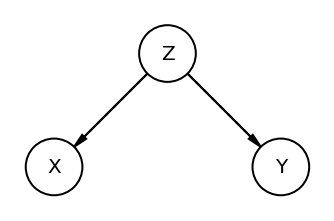

In [59]:
dag_the_fork = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[("Z", "X"), ("Z", "Y")])

pgm = daft.PGM()
coordinates = {"X": (0, 0), "Y" : (2,0), "Z": (1, 1)}
for node in dag_the_fork.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_the_fork.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

Fork is a classic confounder. Z is common cause of X & Y. Learning X tells us nothing about Y

**The Pipe**

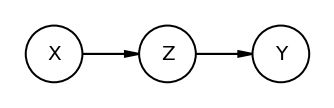

In [60]:
dag_the_pipe = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[("X", "Z"), ("Z", "Y")])

pgm = daft.PGM()
coordinates = {"X": (0, 0), "Y" : (2,0), "Z": (1, 0)}
for node in dag_the_pipe.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_the_pipe.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

If we condition on Z we block the path from X to Y. Recall the treatment & fungus experiment

**The Collider**

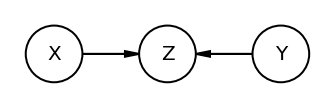

In [61]:
dag_the_collider = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[("X", "Z"), ("Y", "Z")])

pgm = daft.PGM()
coordinates = {"X": (0, 0), "Y" : (2,0), "Z": (1, 0)}
for node in dag_the_collider.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_the_collider.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

Conditioning on collider i.e Z opens the path i.e info flows between X and Y

**The Descendant**

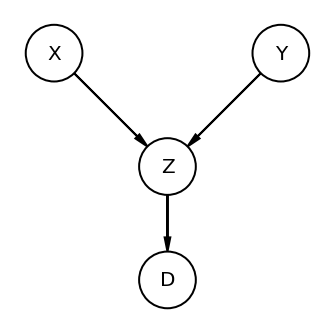

In [62]:
dag_the_descendant = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "D"],
    edges=[("X", "Z"), ("Y", "Z"), ("Z", "D")])

pgm = daft.PGM()
coordinates = {"X": (0, 1), "Y" : (2,1), "Z": (1, 0), "D" : (1,-1)}
for node in dag_the_descendant.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_the_descendant.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

Here is D is the descendant variable. if we condition on it then it will be similar to closig the pipe.

### 6.4.2 Two roads

DAG shown below (Code 6.29) has U which is unobserved variable 

We are interested in X->Y but which observed covariates (A, B, C) do we need to add to the model ?

##### Code 6.29

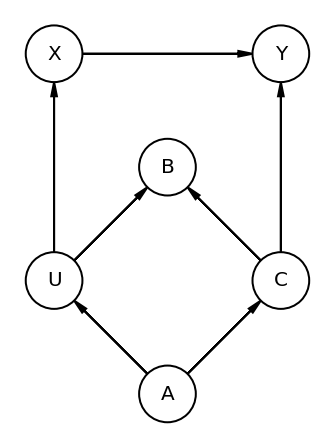

In [63]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[("X", "Y"), ("U", "X"), ("A", "U"), ("A", "C"),
           ("C", "Y"), ("U", "B"), ("C", "B")])


# let's render the DAG as well (note - no code section for it in the book but is displayed)
# so instead of copying the picture we are generating it
pgm = daft.PGM()
coordinates = {"X": (0, 3), "Y" : (2,3), "U": (0, 1), "C": (2, 1), "A": (1, 0), "B" : (1, 2)}
for node in dag_6_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_6_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

In [64]:
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


Read above results as -

Conditioning on either A or C would suffice

### 6.4.3 Backdoor waffles


Let's consider the Waffle House & Divorce rate correlation and with the help of graph we can find the covariates we should include in our model

##### Code 6.30

* S => Whether or not state is in southern USA
* A => Median Age
* M => Marriage Rate
* W => Number of Waffle Houses
* D => Divorce Rate


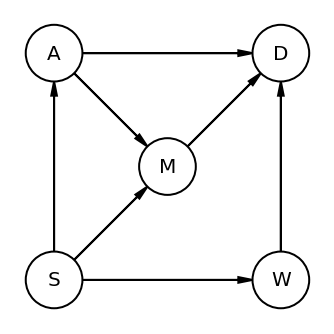

In [65]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[("S", "A"), ("A", "D"),
           ("S", "M"), ("M", "D"),
           ("S", "W"), ("W", "D"),
           ("A", "M")])

# let's render the DAG as well (note - no code section for it in the book but is displayed)
# so instead of copying the picture we are generating it

pgm = daft.PGM()
coordinates = {"S": (0, 0), "W" : (2,0), "A": (0, 2), "D": (2, 2), "M": (1, 1),}
for node in dag_6_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_6_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

In [66]:
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s)for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'A', 'M'})


This shows that we could control either for S alone or A and M

##### Code 6.31

Above DAG is not satisfactory as it assumes that there are **no** unobserved confounds.

We can further test the graph by finding the **conditional independencies**

In [67]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('S', 'D', {'W', 'A', 'M'})
('A', 'W', {'S'})
('M', 'W', {'S'})


Read above result as :

* Marriage Rate & Waffle Houses should be independent if conditioning on S
* Median Age & Waffle Houses should be independent if conditioning on S
* Being in south and Divorce Rate should be indpendent if condition on (W, M and A)